In [1]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import healpy as hp
from tqdm import tqdm_notebook as tqdm
import matplotlib
from matplotlib import rcParams
import pandas as pd
from scipy import integrate, optimize
from scipy.stats import chi2, norm
import emcee
from iminuit import Minuit
import pymultinest
import corner

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext Cython

In [2]:
# Set plotting options
rcParams['xtick.labelsize'] = 20
rcParams['ytick.labelsize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['axes.titlesize'] = 20
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'CMU Serif'
rcParams['figure.figsize'] = (10/1.2,8/1.2)
rcParams['legend.fontsize'] = 16
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [3]:
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis # module for analysing the output

In [4]:
sys.path.append("../DMFiles/")
import particle as pa
from units import *
from constants import *

In [5]:
data_dir = "/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/fermi_data/"
# templates_dir = "/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/templates_example/"

In [6]:
fermi_data = np.load(data_dir+'fermidata_counts.npy').astype(np.int32)
fermi_exposure = np.load(data_dir+'fermidata_exposure.npy')

dif = np.load(data_dir+'template_dif.npy')
iso = np.load(data_dir+'template_iso.npy')
psc = np.load(data_dir+'template_psc.npy')
# psc = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/PS-Maps/ps_map_et3.npy')[ebin]
bub = np.load(data_dir+'template_bub.npy')
dsk = np.load(data_dir+'template_dsk.npy')
# nfw = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW.npy')*fermi_exposure
nfw = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW_gamma_1.2.npy')*fermi_exposure
ps_mask = np.load(data_dir+'fermidata_pscmask.npy')

In [7]:
x_counts, y_counts, error_L, error_H, x_errors_L, x_errors_H = \
[np.array([  1.36887451e-10,   2.56502091e-10,   4.80638086e-10,
          9.00628020e-10,   1.68761248e-09,   3.16227766e-09,
          5.92553098e-09,   1.11033632e-08,   2.08056754e-08,
          3.89860370e-08,   7.30527154e-08]),
 np.array([  1.04000127e+08,   1.83397053e+08,   9.65856820e+07,
          1.51198295e+07,   4.76804443e+06,   9.78677656e+05,
          2.08916332e+05,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00]),
 np.array([  2.14237668e+07,   2.08831658e+07,   1.10708578e+07,
          3.18362798e+06,   1.29929969e+06,   4.21069315e+05,
          1.34538182e+05,  -5.57461814e-04,  -2.97500603e-04,
         -1.58767124e-04,  -8.47292389e-05]),
 np.array([  2.63822671e+07,   2.34164673e+07,   1.24232945e+07,
          3.93887993e+06,   1.71404939e+06,   6.58746511e+05,
          2.74201404e+05,   1.02159419e+05,   5.45194091e+04,
          2.90953689e+04,   1.55273233e+04]),
 np.array([  3.68874510e-11,   6.91203483e-11,   1.29518913e-10,
          2.42694796e-10,   4.54765736e-10,   8.52147960e-10,
          1.59676969e-09,   2.99205487e-09,   5.60656455e-09,
          1.05056783e-08,   1.96857231e-08]),
 np.array([  5.04942913e-11,   9.46170829e-11,   1.77295138e-10,
          3.32218719e-10,   6.22517224e-10,   1.16648362e-09,
          2.18577733e-09,   4.09574765e-09,   7.67468330e-09,
          1.43809553e-08,   2.69472846e-08])]

In [8]:
GCE_options = [0,1]
GCE_tags = ["","_with_GCE_ps"]

In [9]:
xsecs_inj = [1e-26,1e-25,1e-24,1e-23]

In [10]:
templates_dir = "/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/templates_example/"

In [11]:
best_fit_norms = np.load(templates_dir+"best_fit_norms_band_2_ring_30.npy")
dif_bf = np.load(templates_dir+"dif_band_2_ring_30.npy")
iso_bf = np.load(templates_dir+"iso_band_2_ring_30.npy")
psc_bf = np.load(templates_dir+"psc_band_2_ring_30.npy")
bub_bf = np.load(templates_dir+"bub_band_2_ring_30.npy")
dsk_bf = np.load(templates_dir+"dsk_band_2_ring_30.npy")

In [12]:
best_fit_bkg = dif_bf+iso_bf+psc_bf+bub_bf+dsk_bf

In [13]:
def CDF(dxvals,pofx):
    yvals = pofx*dxvals
    sortxvals = np.argsort(yvals)
    yvals = yvals[sortxvals]
    return sortxvals,np.cumsum(yvals)

def PDFSample(xvals,sortxvals,cdf,samples):
    unidraw = np.random.uniform(high=cdf[-1], size=samples)
    cdfdraw = np.searchsorted(cdf, unidraw)
    cdfdraw = sortxvals[cdfdraw]
    return xvals[cdfdraw]

In [14]:
def dNdF_1break(A,n1,n2,Fb1,F):
    if F >= Fb1:
        return A*(F/Fb1)**(-n1)
    else:
        return A*(F/Fb1)**(-n2)
    
def dNdF_2break(A,n1,n2,n3,Fb1,Fb2,F):
    if F >= Fb1:
        return A*(F/Fb1)**(-n1)
    elif F >= Fb2:
        return A*(F/Fb1)**(-n2)
    else:
        return A*(Fb2/Fb1)**(-n2)*(F/Fb2)**(-n3)

In [15]:
analysis_mask_base = cm.make_mask_total(band_mask=True, band_mask_range=2, mask_ring=True, inner=0, outer=30)

In [16]:
analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 

In [17]:
# Jfac_map_NFW = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW.npy')
# Jfac_map_NFW = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW_gamma_1.2.npy')

In [18]:
smoothed_nfw = np.load("/tigress/ljchang/NPTF-IG-Check/Bkg-Maps/JfactorSmoothed/SGH_Jfactor_map_NFW_gamma_1.2_smoothed.npy")

In [19]:
Jfac_map_NFW = smoothed_nfw[10]
nfw = smoothed_nfw[10]*fermi_exposure

In [20]:
ebins = 2*np.logspace(-1,3,41)#[7:39+2]

## Get GCE flux

In [21]:
iGCE = 0

In [22]:
# analysis_mask_base = cm.make_mask_total(band_mask=True, band_mask_range=2, mask_ring=True, inner=0, outer=30)

In [23]:
# nfw = np.load('/tigress/smsharma/Fermi-SmoothGalHalo/DataFiles/SGH_Jfactor_map_NFW_gamma_1.2.npy')*fermi_exposure

In [24]:
n = nptfit.NPTF(work_dir="../",tag="king/scan_data"+GCE_tags[iGCE])
n.load_data(fermi_data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
# analysis_mask = analysis_mask_base > 0
n.load_mask(analysis_mask)

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(psc, 'psc')
n.add_template(bub, 'bub')
n.add_template(dsk, 'dsk')
n.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n.add_template(nfw/rescale, 'nfw_ps', units='PS')
n.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [25]:
n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n.add_non_poiss_model('iso_ps',
                  ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$'],
                  [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[1.5,3.5],[-1,0.5]],
                  [True,False,False,False,True,True])

n.add_non_poiss_model('dsk_ps',
                  ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$'],
                  [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[1.5,3.5],[-1,0.5]],
                  [True,False,False,False,True,True])

if GCE_options[iGCE]:
    n.add_non_poiss_model('nfw_ps',
                          ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                          [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[1.5,3.5],[-1,0.5]],
                          [True,False,False,False,True,True])


pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Loading the psf correction from: /tigress/ljchang/NPTF-IG-Check/Notebooks/psf_dir/gauss_128_0.181_10_50000_1000_0.01.npy
The number of parameters to be fit is 18


In [26]:
n.load_scan()

  analysing data from ../chains/king/scan_data/.txt


In [27]:
an = dnds_analysis.Analysis(n)

In [28]:
# an.make_triangle()

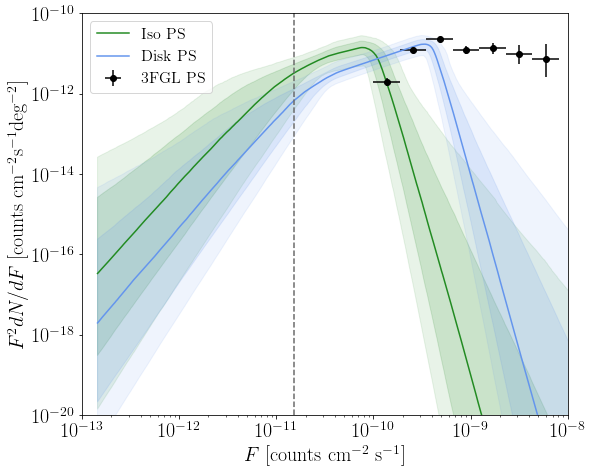

In [29]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)

plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-13,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**0.7/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**3.5/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend()

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
# plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-26}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')
plt.tight_layout()
# plt.savefig('plots/F2dNdF_IG_2break.pdf')

In [30]:
# an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=0,label='Iso PS')
# an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=0)
# an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=0)

# an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=0,label='Disk PS')
# an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=0)
# an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=0)

# if GCE_options[iGCE]:
#     an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=0,label='NFW PS')
#     an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=0)
#     an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=0)

# plt.errorbar(x_counts,y_counts,xerr=[x_errors_L,x_errors_H],yerr=np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(1e-11,1e-8)
# plt.ylim(2e5,2e10)
# plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

# plt.legend()

# plt.ylabel('$dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
# plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
# # plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-26}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')
# # plt.title('3FGL masked')
# plt.tight_layout()
# # plt.savefig('plots/dNdF_IG_2break_masked.pdf')

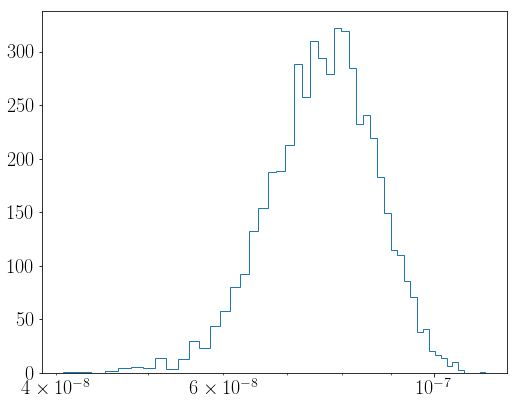

In [31]:
plt.hist(an.return_intensity_arrays_poiss('nfw_dm'),bins=50,histtype='step');
plt.xscale('log')

In [32]:
gce_flux = np.median(an.return_intensity_arrays_poiss('nfw_dm'))

In [33]:
gce_flux

7.779008074038455e-08

## Get GCE PS source-count

In [34]:
iGCE = 1
psf_king = 1

In [35]:
# n = nptfit.NPTF(work_dir="../",tag="scan_data_gamma1p2"+GCE_tags[iGCE])
n = nptfit.NPTF(work_dir="../",tag="king/scan_data_PS_only")
n.load_data(fermi_data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
# analysis_mask = analysis_mask_base > 0
n.load_mask(analysis_mask)

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(psc, 'psc')
n.add_template(bub, 'bub')
n.add_template(dsk, 'dsk')
n.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n.add_template(nfw/rescale, 'nfw_ps', units='PS')
n.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [36]:
###########
# 2-break #
###########

n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
# n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n.add_non_poiss_model('iso_ps',
                  ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$'],
                  [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[0.7,3.5],[-1,0.5]],
                  [True,False,False,False,True,True])

n.add_non_poiss_model('dsk_ps',
                  ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$'],
                  [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[0.7,3.5],[-1,0.5]],
                  [True,False,False,False,True,True])

if GCE_options[iGCE]:
    n.add_non_poiss_model('nfw_ps',
                          ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                          [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[0.7,3.5],[-1,0.5]],
                          [True,False,False,False,True,True])

if psf_king:
    print("Using King PSF function")
    # Define parameters that specify the Fermi-LAT PSF at 2 GeV
    fcore = 0.748988248179
    score = 0.428653790656
    gcore = 7.82363229341
    stail = 0.715962650769
    gtail = 3.61883748683
    spe = 0.00456544262478

    # Define the full PSF in terms of two King functions
    def king_fn(x, sigma, gamma):
        return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

    def Fermi_PSF(r):
        return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

    # Modify the relevant parameters in pc_inst and then make or load the PSF
    pc_inst = pc.PSFCorrection(delay_compute=True)
    pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
    pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
    pc_inst.psf_samples = 10000
    pc_inst.psf_tag = 'Fermi_PSF_2GeV'
    pc_inst.make_or_load_psf_corr()

    # Extract f_ary and df_rho_div_f_ary as usual
    f_ary = pc_inst.f_ary
    df_rho_div_f_ary = pc_inst.df_rho_div_f_ary

else:
    pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
    f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary
n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Using King PSF function
Loading the psf correction from: /tigress/ljchang/NPTF-IG-Check/Notebooks/psf_dir/Fermi_PSF_2GeV.npy
The number of parameters to be fit is 23


In [37]:
n.load_scan()

  analysing data from ../chains/king/scan_data_PS_only/.txt


In [38]:
an = dnds_analysis.Analysis(n)

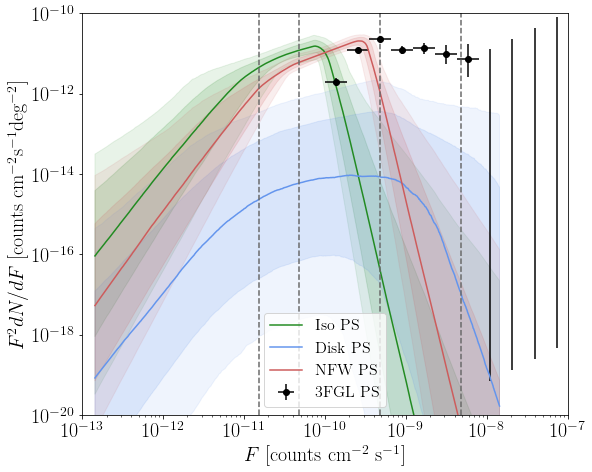

In [39]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)

plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-13,1e-7)
plt.ylim(1e-20,1e-10)

plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
plt.axvline(10**0.5/np.mean(fermi_exposure),ls='--',color='dimgray')
plt.axvline(10**1.5/np.mean(fermi_exposure),ls='--',color='dimgray')
plt.axvline(10**2.5/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend()

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
# plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-26}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')
plt.tight_layout()
# plt.savefig('plots/F2dNdF_IG_2break.pdf')

In [40]:
# an.make_triangle()

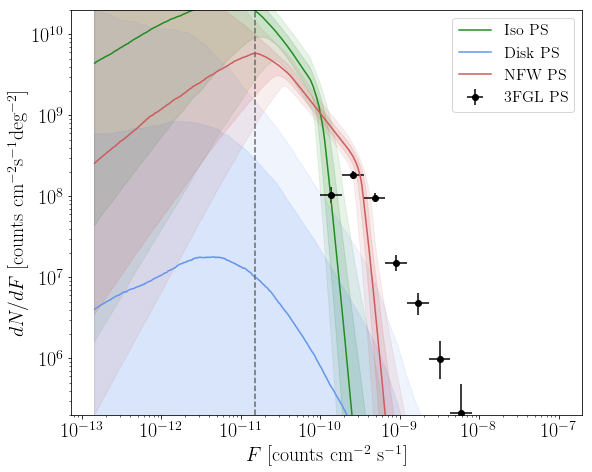

In [41]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=0,label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=0)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=0)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=0,label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=0)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=0)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=0,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=0)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=0)

plt.errorbar(x_counts,y_counts,xerr=[x_errors_L,x_errors_H],yerr=np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
# plt.xlim(1e-11,1e-8)
plt.ylim(2e5,2e10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend()

plt.ylabel('$dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
# plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-26}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')
# plt.title('3FGL masked')
plt.tight_layout()
# plt.savefig('plots/dNdF_IG_2break_masked.pdf')

In [42]:
f_ary0 = np.logspace(-13,-8,100)

In [43]:
dndf_ary = np.array([np.median(an.return_dndf_arrays('nfw_ps',f)) for f in f_ary0])

In [44]:
# an.make_triangle()

## GCE 1-break source-count

In [94]:
iGCE = 1
psf_king = 1

In [95]:
n = nptfit.NPTF(work_dir="../",tag="king/scan_data_1bk")
n.load_data(fermi_data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
# analysis_mask = analysis_mask_base > 0
n.load_mask(analysis_mask)

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(psc, 'psc')
n.add_template(bub, 'bub')
n.add_template(dsk, 'dsk')
n.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n.add_template(nfw/rescale, 'nfw_ps', units='PS')
n.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [96]:
###########
# 1-break #
###########

n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n.add_non_poiss_model('iso_ps',
                      ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$'],
                      [[-10,2],[2.05,15.],[-2,1.95],[-2,2]],
                      [True,False,False,True])

n.add_non_poiss_model('dsk_ps',
                      ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$'],
                      [[-10,2],[2.05,15.],[-2,1.95],[-2,2]],
                      [True,False,False,True])

if GCE_options[iGCE]:
    n.add_non_poiss_model('nfw_ps',
                          ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$'],
                          [[-10,2],[2.05,15.],[-2,1.95],[-2,2]],
                          [True,False,False,True])
    
if psf_king:
    print("Using King PSF function")
    # Define parameters that specify the Fermi-LAT PSF at 2 GeV
    fcore = 0.748988248179
    score = 0.428653790656
    gcore = 7.82363229341
    stail = 0.715962650769
    gtail = 3.61883748683
    spe = 0.00456544262478

    # Define the full PSF in terms of two King functions
    def king_fn(x, sigma, gamma):
        return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

    def Fermi_PSF(r):
        return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

    # Modify the relevant parameters in pc_inst and then make or load the PSF
    pc_inst = pc.PSFCorrection(delay_compute=True)
    pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
    pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
    pc_inst.psf_samples = 10000
    pc_inst.psf_tag = 'Fermi_PSF_2GeV'
    pc_inst.make_or_load_psf_corr()

    # Extract f_ary and df_rho_div_f_ary as usual
    f_ary = pc_inst.f_ary
    df_rho_div_f_ary = pc_inst.df_rho_div_f_ary

else:
    pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
    f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Using King PSF function
Loading the psf correction from: /tigress/ljchang/NPTF-IG-Check/Notebooks/psf_dir/Fermi_PSF_2GeV.npy
The number of parameters to be fit is 18


In [97]:
n.load_scan()

  analysing data from ../chains/king/scan_data_1bk/.txt


In [98]:
an = dnds_analysis.Analysis(n)

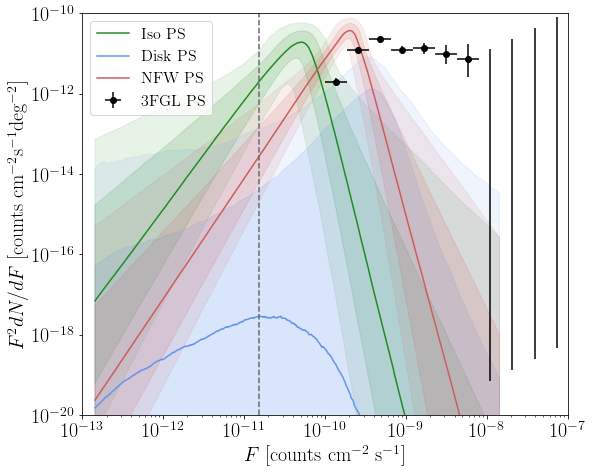

In [100]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)

plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-13,1e-7)
plt.ylim(1e-20,1e-10)

plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend()

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
# plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-26}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')
plt.tight_layout()
# plt.savefig('plots/F2dNdF_IG_2break.pdf')

In [101]:
# an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=0,label='Iso PS')
# an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=0)
# an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=0)

# an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=0,label='Disk PS')
# an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=0)
# an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=0)

# if GCE_options[iGCE]:
#     an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=0,label='NFW PS')
#     an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=0)
#     an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=0)

# plt.errorbar(x_counts,y_counts,xerr=[x_errors_L,x_errors_H],yerr=np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

# plt.yscale('log')
# plt.xscale('log')
# # plt.xlim(1e-11,1e-8)
# plt.ylim(2e5,2e10)
# plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

# plt.legend()

# plt.ylabel('$dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
# plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
# # plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-26}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')
# # plt.title('3FGL masked')
# plt.tight_layout()
# # plt.savefig('plots/dNdF_IG_2break_masked.pdf')

In [102]:
f_ary0 = np.logspace(-13,-8,100)
dndf_ary = np.array([np.median(an.return_dndf_arrays('nfw_ps',f)) for f in f_ary0])

## Simulate NFW point sources

In [45]:
sys.path.append('../../heptools/NPTFit-Sim/NPTFit-Sim/')
import ps_mc

In [46]:
# 2-break 
raw_A = np.log10(np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[0])*0.85)
raw_n = np.array([np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[1][0]),np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[1][1]),np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[1][2])])
raw_S = np.array([np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[2][0]),np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[2][1])/10])

In [47]:
# # 1-break

# raw_A = np.log10(np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[0])*0.5)
# raw_n = np.array([np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[1][0]),np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[1][1])])
# raw_S = np.array([np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[2][0])])


In [48]:
name = "example" # Name of output file

In [49]:
temp = nfw
# temp = np.load(data_dir+"template_gce.npy")

In [50]:
# Calculate the mean Fermi exposure
mean_exp = np.mean(fermi_exposure)
# Convert from counts to flux
F = raw_S / mean_exp
# Multiply log-normilization term, A, by log-mean exposure to convert to SCD in terms of flux.
cor_term = np.log10(mean_exp)
A = raw_A + cor_term

rescale = fermi_exposure/mean_exp
temp = temp/rescale

In [51]:
# Define parameters that specify the Fermi-LAT PSF at 2 GeV
fcore = 0.748988248179
score = 0.428653790656
gcore = 7.82363229341
stail = 0.715962650769
gtail = 3.61883748683
spe = 0.00456544262478

# Define the full PSF in terms of two King functions
def king_fn(x, sigma, gamma):
    return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

def Fermi_PSF(r):
    return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

# Lambda function to pass user defined PSF, includes Jacobian factor
psf_r = lambda r: Fermi_PSF(r)

In [52]:
exp_masked = ma.masked_array(data=fermi_exposure, mask=analysis_mask)
exp_masked_compressed = exp_masked.compressed()
exp_masked_mean = np.mean(exp_masked_compressed)

In [53]:
area_mask = np.sum(1-analysis_mask)*hp.nside2pixarea(128)*np.rad2deg(1)**2
rf = np.sum(temp)*exp_masked_mean/area_mask

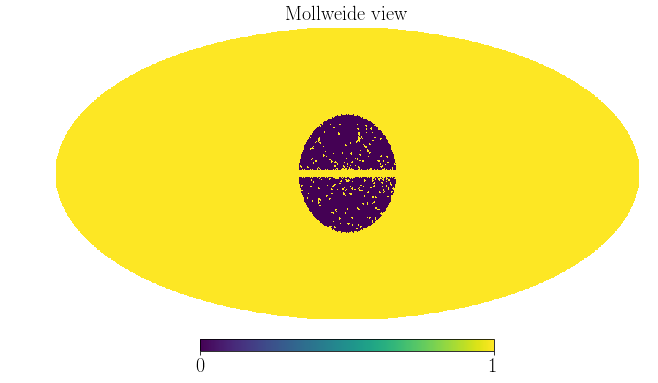

In [54]:
hp.mollview(analysis_mask)

In [142]:
sim = ps_mc.run(raw_n,F,A,temp,fermi_exposure,psf_r)

Number of sources from Poisson draw: 574
Sampling the source count distribution.
Simulating counts map ...
Done simulation.


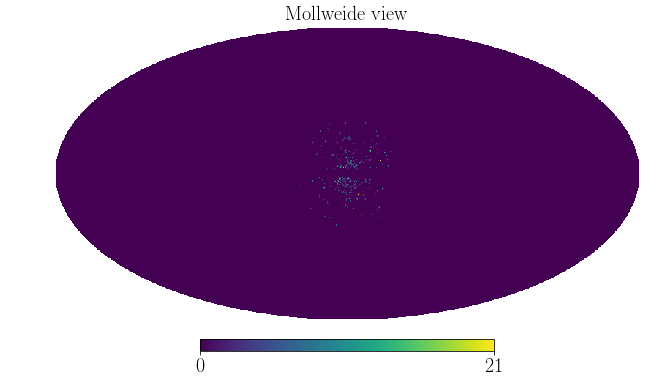

In [143]:
hp.mollview(~analysis_mask*sim)

In [56]:
# plt.plot(f_ary0,dndf_ary)
# plt.plot(f_ary0,rf*np.array([dNdF_1break(10**raw_A,*raw_n,*raw_S/exp_masked_mean,f) for f in f_ary0]))
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(1e-13,1e-8)
# # plt.ylim(1e-20,1e-10)

(1e-13, 1e-08)

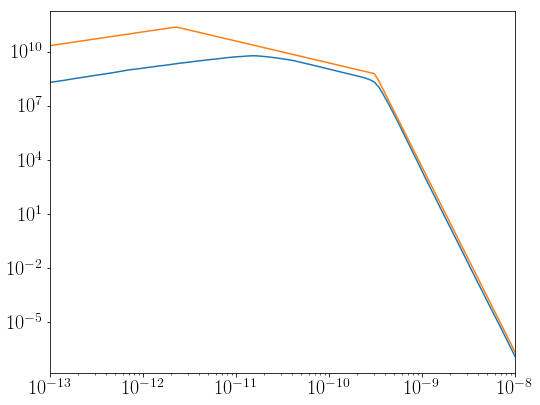

In [57]:
plt.plot(f_ary0,dndf_ary)
plt.plot(f_ary0,rf*np.array([dNdF_2break(10**raw_A,*raw_n,*raw_S/exp_masked_mean,f) for f in f_ary0]))
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-13,1e-8)
# plt.ylim(1e-20,1e-10)

In [146]:
np.sum(~analysis_mask*sim)/exp_masked_mean/gce_flux

0.5502940411798525

In [147]:
np.sum(~analysis_mask*sim)/exp_masked_mean

4.2807417894333224e-08

In [148]:
gce_flux

7.779008074038455e-08

In [149]:
np.savez("../data/kingPSF_NFW_PS_1bk_50_GCE_flux",SCD_params=np.hstack((10**raw_A,raw_n,raw_S)),counts_map=sim)

In [151]:
sim_PS = np.load("../data/kingPSF_NFW_PS_1bk_100_GCE_flux.npz")['counts_map']

# for MC in tqdm(range(10)):
for MC in [0]:
    save_tag = 'PS_1bk_100_' + str(MC)
    sum_data = np.random.poisson(best_fit_bkg+sim_PS)
    np.save('../data/GCE_MC/king_smoothed/'+save_tag+'.npy',sum_data)  

In [58]:
cross_section = 1.3e-26
mchi = 40
particle = pa.Particle(channel='b', m_chi = mchi * GeV)
inj_sig_map = np.zeros(hp.nside2npix(128))
inj_sig_map = Jfac_map_NFW*particle.Phi(cross_section*Centimeter**3*Sec**-1,2*GeV, 20*GeV)/(Centimeter**-2*Sec**-1)
inj_sig_map *= fermi_exposure

sim_PS = np.load("../data/kingPSF_NFW_PS_100_GCE_flux_below1ph.npz")['counts_map']

# for MC in tqdm(range(10)):
for MC in [0]:
    save_tag = 'PS_below1ph_smoothDM_40GeV_100_100_' + str(MC)
    sum_data = np.random.poisson(best_fit_bkg+inj_sig_map+sim_PS)
    np.save('../data/GCE_MC/king_smoothed/'+save_tag+'.npy',sum_data)  

/tigress/ljchang/heptools/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [172]:
sim_PS_only = np.load("../data/kingPSF_NFW_PS_100_GCE_flux.npz")['counts_map']
for MC in tqdm(range(10)):
#     for MC in [0]:
    save_tag = 'PS_' + str(MC)
    sum_data = np.random.poisson(best_fit_bkg+sim_PS_only)
    np.save('../data/GCE_MC/king_smoothed/'+save_tag+'.npy',sum_data)  

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

## Simulate bubbles-distributed point sources

In [129]:
raw_A = np.log10(np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[0])*0.9)

In [130]:
n = np.array([np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[1][0]),np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[1][1]),np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[1][2])])

In [131]:
S = np.array([np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[2][0]),np.median(an.return_non_poiss_parameter_posteriors('nfw_ps')[2][1])])

In [132]:
exp_masked = ma.masked_array(data=fermi_exposure, mask=analysis_mask)
exp_masked_compressed = exp_masked.compressed()
exp_masked_mean = np.mean(exp_masked_compressed)

In [133]:
area_mask = np.sum(1-analysis_mask)*hp.nside2pixarea(128)*np.rad2deg(1)**2
rf = np.sum(temp)*exp_masked_mean/area_mask

In [58]:
name = "example" # Name of output file

In [59]:
nfw_masked = ma.masked_array(data=nfw, mask=analysis_mask)
nfw_masked_compressed = nfw_masked.compressed()

bub_masked = ma.masked_array(data=bub, mask=analysis_mask)
bub_masked_compressed = bub_masked.compressed()


In [60]:
temp = bub*np.mean(nfw_masked_compressed)/np.mean(bub_masked_compressed)

In [61]:
# Calculate the mean Fermi exposure
mean_exp = np.mean(fermi_exposure)
# Convert from counts to flux
F = S / mean_exp
# Multiply log-normilization term, A, by log-mean exposure to convert to SCD in terms of flux.
cor_term = np.log10(mean_exp)
A = raw_A + cor_term

rescale = fermi_exposure/mean_exp
temp = temp/rescale

In [62]:
# Define parameters that specify the Fermi-LAT PSF at 2 GeV
fcore = 0.748988248179
score = 0.428653790656
gcore = 7.82363229341
stail = 0.715962650769
gtail = 3.61883748683
spe = 0.00456544262478

# Define the full PSF in terms of two King functions
def king_fn(x, sigma, gamma):
    return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

def Fermi_PSF(r):
    return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

# Lambda function to pass user defined PSF, includes Jacobian factor
psf_r = lambda r: Fermi_PSF(r)

In [65]:
sim = ps_mc.run(n,F,A,temp,fermi_exposure,psf_r)

Number of sources from Poisson draw: 1757
Sampling the source count distribution.
Simulating counts map ...
Done simulation.


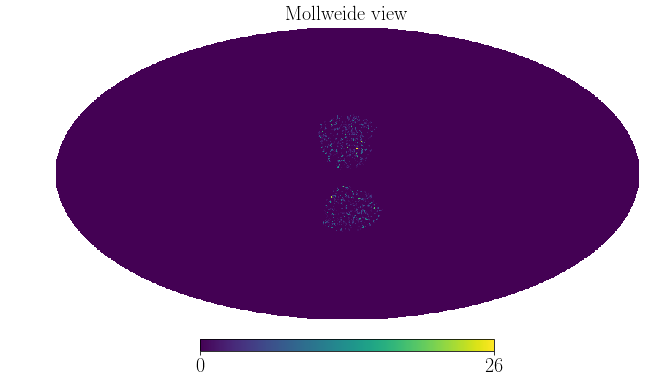

In [66]:
hp.mollview(~analysis_mask*sim)

In [143]:
np.sum(~analysis_mask*sim)/np.sum(~analysis_mask*(sim+inj_sig_map+best_fit_bkg))

0.016130769016841018

(1e-13, 1e-08)

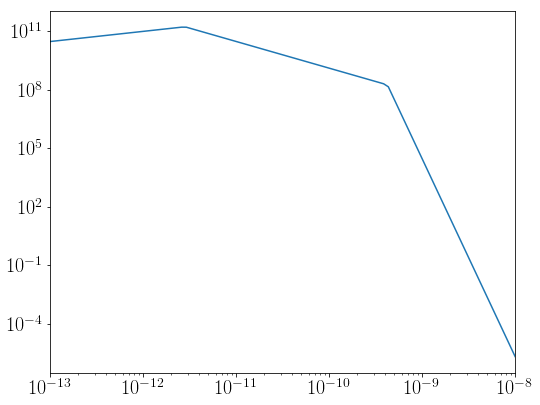

In [135]:
# plt.plot(f_ary,dndf_ary)
plt.plot(f_ary0,rf*np.array([dNdF_2break(10**raw_A,*n,*S/exp_masked_mean,f) for f in f_ary0]))
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-13,1e-8)
# plt.ylim(1e-20,1e-10)

In [262]:
np.savez("../data/kingPSF_bub_PS_50_GCE_flux",SCD_params=np.hstack((10**raw_A,n,S)),counts_map=sim)

In [263]:
sim_PS_only = np.load("../data/kingPSF_bub_PS_100_GCE_flux.npz")['counts_map']
for MC in tqdm(range(10)):
#     for MC in [0]:
    save_tag = 'bubPS_' + str(MC)
    sum_data = np.random.poisson(best_fit_bkg+sim_PS_only)
    np.save('../data/GCE_MC/king_smoothed/'+save_tag+'.npy',sum_data)  

HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

## Simulate smooth DM signal

In [24]:
# Combine background maps with injected signal, poisson fluctuate to get MCs
file_path = "/tigress/ljchang/NPTF_test/data/"
mchi = 40

particle = pa.Particle(channel='b', m_chi = mchi * GeV)

# cross_section = 1.3e-26
cross_section = 0.7e-26
inj_sig_map = np.zeros(hp.nside2npix(128))
inj_sig_map = Jfac_map_NFW*particle.Phi(cross_section*Centimeter**3*Sec**-1,2*GeV, 20*GeV)/(Centimeter**-2*Sec**-1)
inj_sig_map *= fermi_exposure

# for MC in tqdm(range(10)):
# #     for MC in [0]:
#     save_tag = 'smoothDM_40GeV_1p3em26_' + str(MC)
#     sum_data = np.random.poisson(best_fit_bkg+inj_sig_map)
#     np.save(file_path+'GCE_MC/'+save_tag+'.npy',sum_data)  

#     sum_data = []
#     for ebin in range(emin,emax+1):
#         sum_data.append(fermi_data_ebins[ebin]+np.random.poisson(inj_sig_ebins)[ebin])
#     np.save(file_path+'injected_signal/data/'+str(mchi)+'GeV/xbin_'+str(xsec_ind)+'.npy',sum_data)

/tigress/ljchang/heptools/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [191]:
sum_data = np.random.poisson(best_fit_bkg+inj_sig_map) + np.random.poisson(inj_sig_map)
np.save('../data/GCE_MC/king_smoothed/double_smoothDM_40GeV_1p3em26.npy',sum_data)

In [255]:
sum_data = np.random.poisson(best_fit_bkg)+np.random.poisson(2*inj_sig_map)
np.save('../data/GCE_MC/king_smoothed/twice_smoothDM_40GeV_1p3em26.npy',sum_data)

In [192]:
# for MC in tqdm(range(10)):
# #     for MC in [0]:
#     save_tag = 'smoothDM_40GeV_1p3em26_' + str(MC)
#     sum_data = np.random.poisson(best_fit_bkg+inj_sig_map)
#     np.save('../data/GCE_MC/king_smoothed/'+save_tag+'.npy',sum_data)  

In [193]:
# for MC in tqdm(range(10)):
# #     for MC in [0]:
#     save_tag = 'smoothDM_40GeV_0p7em26_' + str(MC)
#     sum_data = np.random.poisson(best_fit_bkg+inj_sig_map)
#     np.save('../data/GCE_MC/king_smoothed/'+save_tag+'.npy',sum_data)  

In [264]:
# sim_PS_50 = np.load("../data/kingPSF_PS_50_GCE_flux.npz")['counts_map']

# for MC in tqdm(range(10)):
# #     for MC in [0]:
#     save_tag = 'PS_smoothDM_40GeV_0p7em26_' + str(MC)
#     sum_data = np.random.poisson(best_fit_bkg+inj_sig_map+sim_PS_50)
#     np.save('../data/GCE_MC/king_smoothed/'+save_tag+'.npy',sum_data)  

In [273]:
cross_section = 0.7e-26
inj_sig_map = np.zeros(hp.nside2npix(128))
inj_sig_map = Jfac_map_NFW*particle.Phi(cross_section*Centimeter**3*Sec**-1,2*GeV, 20*GeV)/(Centimeter**-2*Sec**-1)
inj_sig_map *= fermi_exposure

sim_PS_50 = np.load("../data/kingPSF_bub_PS_50_GCE_flux.npz")['counts_map']

for MC in tqdm(range(10)):
#     for MC in [0]:
    save_tag = 'bubPS_smoothDM_40GeV_0p7em26_50_50_' + str(MC)
    sum_data = np.random.poisson(best_fit_bkg+inj_sig_map+sim_PS_50)
    np.save('../data/GCE_MC/king_smoothed/'+save_tag+'.npy',sum_data)  

/tigress/ljchang/heptools/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

In [274]:
cross_section = 1.3e-26
inj_sig_map = np.zeros(hp.nside2npix(128))
inj_sig_map = Jfac_map_NFW*particle.Phi(cross_section*Centimeter**3*Sec**-1,2*GeV, 20*GeV)/(Centimeter**-2*Sec**-1)
inj_sig_map *= fermi_exposure

sim_PS_100 = np.load("../data/kingPSF_bub_PS_100_GCE_flux.npz")['counts_map']

for MC in tqdm(range(10)):
#     for MC in [0]:
    save_tag = 'bubPS_smoothDM_40GeV_0p7em26_100_100_' + str(MC)
    sum_data = np.random.poisson(best_fit_bkg+inj_sig_map+sim_PS_100)
    np.save('../data/GCE_MC/king_smoothed/'+save_tag+'.npy',sum_data)  

/tigress/ljchang/heptools/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


HBox(children=(IntProgress(value=0, max=10), HTML(value='')))

## Load scans

In [25]:
exp_masked = ma.masked_array(data=fermi_exposure, mask=analysis_mask)
exp_masked_compressed = exp_masked.compressed()
exp_masked_mean = np.mean(exp_masked_compressed)

In [29]:
area_mask = np.sum(1-analysis_mask)*hp.nside2pixarea(128)*np.rad2deg(1)**2
rf = np.sum(nfw/rescale)*exp_masked_mean/area_mask

In [30]:
# file_tag_types = ["smoothDM_40GeV_1p3em26","PS_smoothDM_40GeV_0p7em26","PS"]
# MC_dir = "/tigress/ljchang/NPTF-IG-Check/data/GCE_MC/king_smoothed/"
file_tag_types = ["PS_below1ph_smoothDM_40GeV_50_50"]
MC_dir = "/tigress/ljchang/NPTF-IG-Check/data/GCE_MC/"

In [31]:
f_ary0 = np.logspace(-13,-8,100)

In [32]:
iGCE = 1
filetype = 1
MC = 0
psf_king = 1

In [33]:
if filetype == 0: # Smooth DM only
    if psf_king:
        trueflux_dm = 0.032926293047738496 # King PSF
    else:
        trueflux_dm = 0.032817734420630365 # No PSF smoothing
    trueflux_ps = 0
    
elif filetype == 1: # 50% smooth DM, 50% NFW PS
    cross_section = 0.7e-26
    inj_sig_map = np.zeros(hp.nside2npix(128))
    inj_sig_map = Jfac_map_NFW*particle.Phi(cross_section*Centimeter**3*Sec**-1,2*GeV, 20*GeV)/(Centimeter**-2*Sec**-1)
    inj_sig_map *= fermi_exposure

    if psf_king:
#         sim_SCD = np.load("../data/kingPSF_NFW_PS_50_GCE_flux.npz")['SCD_params']
#         sim_map = np.load("../data/kingPSF_NFW_PS_50_GCE_flux.npz")['counts_map']
        sim_SCD = np.load("../data/kingPSF_NFW_PS_50_GCE_flux_below1ph.npz")['SCD_params']
        sim_map = np.load("../data/kingPSF_NFW_PS_50_GCE_flux_below1ph.npz")['counts_map']

    else:
        trueflux_dm = 0.01794286195497843 # No PSF smoothing
        sim_SCD = np.load("../data/NFW_PS_50_GCE_flux.npz")['SCD_params'] 
        sim_map = np.load("../data/NFW_PS_50_GCE_flux.npz")['counts_map']
        
    trueflux_dm = np.sum(~analysis_mask*inj_sig_map)/np.sum(~analysis_mask*(inj_sig_map+sim_map+best_fit_bkg))
    trueflux_ps = np.sum(~analysis_mask*sim_map)/np.sum(~analysis_mask*(inj_sig_map+sim_map+best_fit_bkg))
    
elif filetype == 2: # NFW PS only
    if psf_king:
        sim_SCD = np.load("../data/kingPSF_NFW_PS_100_GCE_flux.npz")['SCD_params']
        sim_map = np.load("../data/kingPSF_NFW_PS_100_GCE_flux.npz")['counts_map']
    else:    
        sim_SCD = np.load("../data/NFW_PS_100_GCE_flux.npz")['SCD_params']
        sim_map = np.load("../data/NFW_PS_100_GCE_flux.npz")['counts_map']
    trueflux_dm = 0
    trueflux_ps = np.sum(~analysis_mask*sim_map)/np.sum(~analysis_mask*(best_fit_bkg+sim_map))
    
# elif filetype == 3: # Bubbles PS only
#     if psf_king:
#         trueflux_dm = 0
#         sim_SCD = np.load("../data/kingPSF_bub_PS_100_GCE_flux.npz")['SCD_params']
#         sim_map = np.load("../data/kingPSF_bub_PS_100_GCE_flux.npz")['counts_map']
#         trueflux_ps = np.sum(~analysis_mask*sim_map)/np.sum(~analysis_mask*(best_fit_bkg+sim_map))
    
# elif filetype == 4: # 100% smooth DM, 100% bubbles PS 
#     if psf_king:
#         trueflux_dm = 0.032926293047738496
#         sim_SCD = np.load("../data/kingPSF_bub_PS_100_GCE_flux.npz")['SCD_params']
#         sim_map = np.load("../data/kingPSF_bub_PS_100_GCE_flux.npz")['counts_map']
#         trueflux_ps = np.sum(~analysis_mask*sim_map)/np.sum(~analysis_mask*(best_fit_bkg+sim_map))

# elif filetype == 5: # 50% smooth DM, 50% bubbles PS 
#     if psf_king:
#         trueflux_dm = 0.018003131510579643
#         sim_SCD = np.load("../data/kingPSF_bub_PS_50_GCE_flux.npz")['SCD_params']
#         sim_map = np.load("../data/kingPSF_bub_PS_50_GCE_flux.npz")['counts_map']
#         trueflux_ps = np.sum(~analysis_mask*sim_map)/np.sum(~analysis_mask*(best_fit_bkg+sim_map))

/tigress/ljchang/heptools/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [34]:
data = np.load("/tigress/ljchang/NPTF-IG-Check/data/GCE_MC/king_smoothed/PS_below1ph_smoothDM_40GeV_50_50_0.npy").astype('int32')

In [35]:
# data = np.load(MC_dir+file_tag_types[filetype]+"_"+str(MC)+".npy").astype('int32')
# data = np.load('/tigress/ljchang/NPTF-IG-Check/data/GCE_MC/king_smoothed/twice_smoothDM_40GeV_1p3em26.npy').astype('int32')

In [50]:
# n = nptfit.NPTF(work_dir="../",tag="king/scan_"+file_tag_types[filetype]+"_"+str(MC)+GCE_tags[iGCE])
# n = nptfit.NPTF(work_dir="../",tag="king/scan_below1phPS_DM"+GCE_tags[iGCE])
n = nptfit.NPTF(work_dir="../",tag="king/scan_below1phPS_DM_fix30ph2")
n.load_data(data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
n.load_mask(analysis_mask)

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(psc, 'psc')
n.add_template(bub, 'bub')
n.add_template(dsk, 'dsk')
n.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n.add_template(nfw/rescale, 'nfw_ps', units='PS')
n.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [51]:
n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n.add_non_poiss_model('iso_ps',
                  ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$'],
                  [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[0.7,3.5],[-1,0.5]],
                  [True,False,False,False,True,True])

n.add_non_poiss_model('dsk_ps',
                  ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$'],
                  [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[0.7,3.5],[-1,0.5]],
                  [True,False,False,False,True,True])

if GCE_options[iGCE]:
#     n.add_non_poiss_model('nfw_ps',
#                       ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
#                       [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[0.7,3.5],[-2,0.5]],
#                       [True,False,False,False,True,True])
    n.add_non_poiss_model('nfw_ps',
                          ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                          [[-10,2],[2.05,15.],[1.05,1.95],[0.7,3.5]],
                          [True,False,False,True],
                          fixed_params=[[3,-10],[5,30]])
if psf_king:
    print("Using King PSF function")
    # Define parameters that specify the Fermi-LAT PSF at 2 GeV
    fcore = 0.748988248179
    score = 0.428653790656
    gcore = 7.82363229341
    stail = 0.715962650769
    gtail = 3.61883748683
    spe = 0.00456544262478

    # Define the full PSF in terms of two King functions
    def king_fn(x, sigma, gamma):
        return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

    def Fermi_PSF(r):
        return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

    # Modify the relevant parameters in pc_inst and then make or load the PSF
    pc_inst = pc.PSFCorrection(delay_compute=True)
    pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
    pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
    pc_inst.psf_samples = 10000
    pc_inst.psf_tag = 'Fermi_PSF_2GeV'
    pc_inst.make_or_load_psf_corr()

    # Extract f_ary and df_rho_div_f_ary as usual
    f_ary = pc_inst.f_ary
    df_rho_div_f_ary = pc_inst.df_rho_div_f_ary
else:
    pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
    f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Using King PSF function
Loading the psf correction from: /tigress/ljchang/NPTF-IG-Check/Notebooks/psf_dir/Fermi_PSF_2GeV.npy
The number of parameters to be fit is 22


In [52]:
n.load_scan()

  analysing data from ../chains/king/scan_below1phPS_DM_fix30ph2/.txt


In [53]:
an = dnds_analysis.Analysis(n)

In [54]:
# an.make_triangle()
# plt.savefig('plots/GCE_MC/corner_'+file_tag_types[filetype]+"_"+str(MC)+GCE_tags[iGCE]+'.pdf')

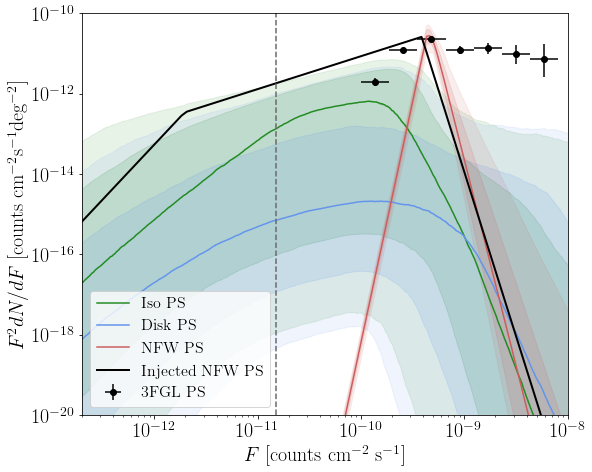

In [55]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)
if not filetype == 0:
    plt.plot(f_ary0,f_ary0**2*rf*np.array([dNdF_2break(*sim_SCD[0:4],*sim_SCD[4:6]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected NFW PS')
plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**0.7/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**3.5/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend(loc='lower left')

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
# plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-26}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')
plt.tight_layout()
# plt.savefig('plots/GCE_MC/F2dNdF_'+file_tag_types[filetype]+"_"+str(MC)+GCE_tags[iGCE]+'.pdf')
# plt.savefig('plots/GCE_MC/kingPSF/NFWPS_below1ph/F2dNdF'+GCE_tags[iGCE]+'.pdf')
# plt.savefig('plots/GCE_MC/kingPSF/NFWPS_below1ph/F2dNdF_fix2ph.pdf')


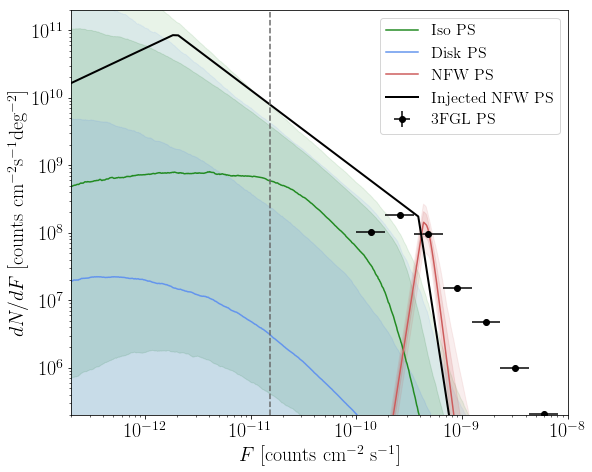

In [56]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1)

if GCE_options[iGCE]:
    an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',label='NFW PS')
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15)
    an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1)
if not filetype == 0:
    plt.plot(f_ary0,rf*np.array([dNdF_2break(*sim_SCD[0:4],*sim_SCD[4:6]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected NFW PS')
plt.errorbar(x_counts,y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(2e5,2e11)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend(loc='upper right')

plt.ylabel('$dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
# plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-26}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')
plt.tight_layout()
# plt.savefig('plots/GCE_MC/F2dNdF_'+file_tag_types[filetype]+"_"+str(MC)+GCE_tags[iGCE]+'.pdf')
# plt.savefig('plots/GCE_MC/kingPSF/NFWPS_below1ph/dNdF'+GCE_tags[iGCE]+'.pdf')
# plt.savefig('plots/GCE_MC/kingPSF/NFWPS_below1ph/dNdF_fix2ph.pdf')


In [392]:
np.sum(~analysis_mask*inj_sig_map)/exp_masked_mean

4.2407721022931636e-08

In [393]:
np.sum(~analysis_mask*sim_map)/exp_masked_mean

3.862020491710601e-08

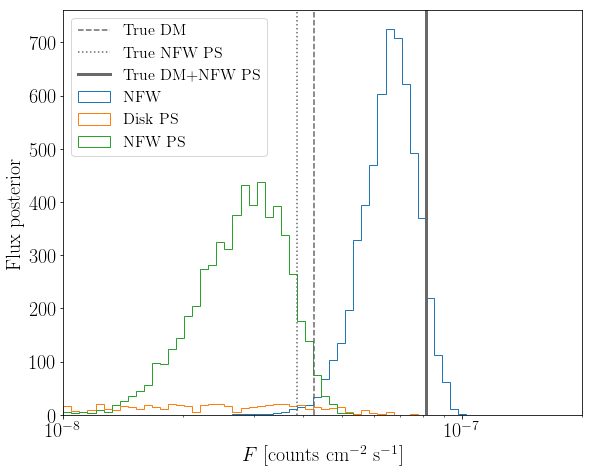

In [57]:
plt.hist(an.return_intensity_arrays_poiss('nfw_dm'),bins=np.logspace(-8,-6,100),histtype='step',label='NFW');
plt.hist(an.return_intensity_arrays_non_poiss('dsk_ps'),bins=np.logspace(-8,-6,100),histtype='step',label='Disk PS');
if GCE_options[iGCE]:
    plt.hist(an.return_intensity_arrays_non_poiss('nfw_ps'),bins=np.logspace(-8,-6,100),histtype='step', label='NFW PS')

plt.axvline(np.sum(~analysis_mask*inj_sig_map)/exp_masked_mean,color='dimgray',ls='--',label='True DM')
plt.axvline(np.sum(~analysis_mask*sim_map)/exp_masked_mean,color='dimgray',ls='dotted',label='True NFW PS')
plt.axvline(np.sum(~analysis_mask*sim_map)/exp_masked_mean+np.sum(~analysis_mask*inj_sig_map)/exp_masked_mean,color='dimgray',label='True DM+NFW PS',linewidth=3)

plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
plt.ylabel('Flux posterior')

plt.xlim(1e-8,2e-7)
plt.legend(loc='upper left')
plt.xscale('log')
plt.tight_layout()

# plt.savefig('plots/GCE_MC/kingPSF/NFWPS_below1ph/fluxes'+GCE_tags[iGCE]+'.pdf')
# plt.savefig('plots/GCE_MC/kingPSF/NFWPS_below1ph/fluxes_fix2ph.pdf')


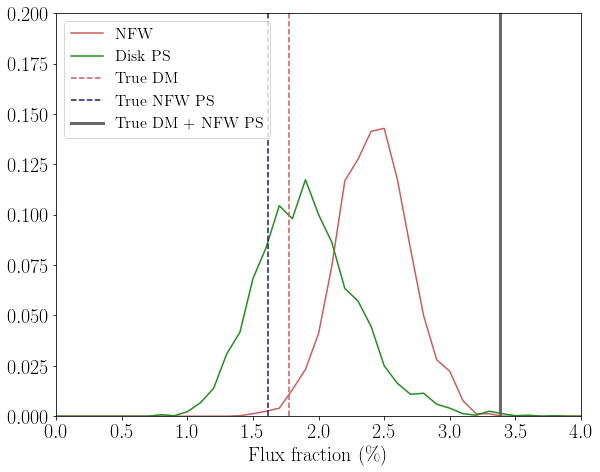

In [299]:
# an.plot_intensity_fraction_poiss('iso', bins=1000, color='forestgreen', label='Iso',qs=[])
# an.plot_intensity_fraction_poiss('psc', bins=1000, color='gray', label='3FGL',qs=[])
# an.plot_intensity_fraction_poiss('bub', bins=1000, color='darkgoldenrod', label='Bub',qs=[])
# an.plot_intensity_fraction_poiss('dsk', bins=1000, color='cornflowerblue', label='Disk',qs=[])
an.plot_intensity_fraction_poiss('nfw_dm', bins=1000, color='indianred', label='NFW',qs=[])

an.plot_intensity_fraction_non_poiss('dsk_ps',bins=1000, color='forestgreen', label='Disk PS',qs=[])

if GCE_options[iGCE]:
    an.plot_intensity_fraction_non_poiss('nfw_ps',bins=1000, color='midnightblue', label='NFW PS',qs=[])

plt.axvline(trueflux_dm*100,color='indianred',label='True DM',ls='--')
plt.axvline(trueflux_ps*100,color='midnightblue',label='True NFW PS',ls='--')

plt.axvline((trueflux_dm+trueflux_ps)*100,color='dimgray',label='True DM + NFW PS',linewidth=3)


# plt.text(trueflux_dm*100-0.5,0.5,'True DM',rotation=90,fontsize=16,color='dimgray')
# plt.text(trueflux_ps*100+0.5,0.5,'True NFW PS',rotation=90,fontsize=16,color='dimgray')

plt.legend(loc='upper left')
plt.xlim(0,4);
plt.ylim(0,0.2);
plt.xlabel(r'Flux fraction (\%)')
plt.tight_layout()
# plt.savefig('plots/GCE_MC/flux_fractions_'+file_tag_types[filetype]+"_"+str(MC)+GCE_tags[iGCE]+'.pdf')
plt.savefig('plots/GCE_MC/kingPSF/NFWPS_below1ph/flux_fractions'+GCE_tags[iGCE]+'.pdf')
# plt.savefig('plots/GCE_MC/kingPSF/NFWPS_below1ph/flux_fractions_fix1ph.pdf')


## Load bubbles scans

In [20]:
MC_dir = "/tigress/ljchang/NPTF-IG-Check/data/GCE_MC/king_smoothed/"

In [21]:
file_tag_types = ["bubPS","bubPS_smoothDM_40GeV_0p7em26_100_100","bubPS_smoothDM_40GeV_0p7em26_50_50"]

In [77]:
exp_masked = ma.masked_array(data=fermi_exposure, mask=analysis_mask)
exp_masked_compressed = exp_masked.compressed()
exp_masked_mean = np.mean(exp_masked_compressed)

In [79]:
area_mask = np.sum(1-analysis_mask)*hp.nside2pixarea(128)*np.rad2deg(1)**2
rf = np.sum(temp)*exp_masked_mean/area_mask

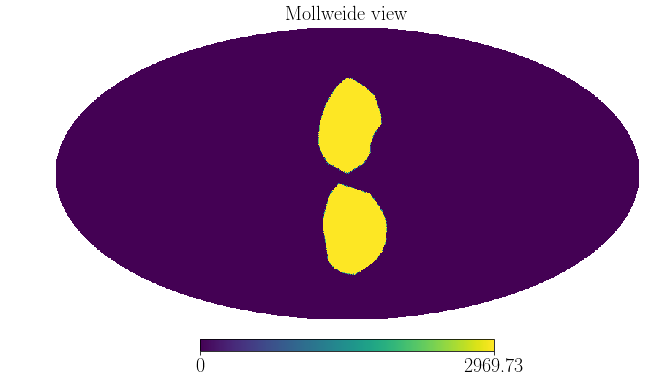

In [80]:
hp.mollview(temp)

In [34]:
f_ary0 = np.logspace(-13,-8,100)

In [103]:
MC = 0
filetype = 1
iGCE = 1
psf_king = 1

In [104]:
if filetype == 0: # Bubbles PS only
    if psf_king:
        trueflux_dm = 0
        sim_SCD = np.load("../data/kingPSF_bub_PS_100_GCE_flux.npz")['SCD_params']
        sim_map = np.load("../data/kingPSF_bub_PS_100_GCE_flux.npz")['counts_map']
        trueflux_ps = np.sum(~analysis_mask*sim_map)/np.sum(~analysis_mask*(best_fit_bkg+sim_map))
    
elif filetype == 1: # 100% smooth DM, 100% bubbles PS 
    if psf_king:
        trueflux_dm = 0.032926293047738496
        sim_SCD = np.load("../data/kingPSF_bub_PS_100_GCE_flux.npz")['SCD_params']
        sim_map = np.load("../data/kingPSF_bub_PS_100_GCE_flux.npz")['counts_map']
        trueflux_ps = np.sum(~analysis_mask*sim_map)/np.sum(~analysis_mask*(best_fit_bkg+sim_map))

elif filetype == 2: # 50% smooth DM, 50% bubbles PS 
    if psf_king:
        trueflux_dm = 0.018003131510579643
        sim_SCD = np.load("../data/kingPSF_bub_PS_50_GCE_flux.npz")['SCD_params']
        sim_map = np.load("../data/kingPSF_bub_PS_50_GCE_flux.npz")['counts_map']
        trueflux_ps = np.sum(~analysis_mask*sim_map)/np.sum(~analysis_mask*(best_fit_bkg+sim_map))

In [105]:
data = np.load(MC_dir+file_tag_types[filetype]+"_"+str(MC)+".npy").astype('int32')

In [106]:
run_tag = "scan_100_100"

In [107]:
n = nptfit.NPTF(work_dir="../",tag="king/bubPS_DM/"+run_tag)
n.load_data(data, fermi_exposure)

analysis_mask = analysis_mask_base + ps_mask
analysis_mask = analysis_mask > 0 
n.load_mask(analysis_mask)

n.add_template(dif, 'dif')
n.add_template(iso, 'iso')
n.add_template(psc, 'psc')
n.add_template(bub, 'bub')
n.add_template(dsk, 'dsk')
n.add_template(nfw, 'nfw_dm')

iso_ps = np.ones(len(iso))
n.add_template(iso_ps, 'iso_ps',units='PS')
# Remove the exposure correction for PS templates
rescale = fermi_exposure/np.mean(fermi_exposure)
n.add_template(nfw/rescale, 'nfw_ps', units='PS')
n.add_template(bub/rescale, 'bub_ps', units='PS')
n.add_template(dsk/rescale, 'dsk_ps', units='PS')

In [108]:
n.add_poiss_model('dif', '$A_\mathrm{dif}$', [0,20], False)
n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,2], False)
n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,2], False)
n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,2], False)
n.add_poiss_model('dsk', '$A_\mathrm{dsk}$', [0,2], False)
n.add_poiss_model('nfw_dm', '$A_\mathrm{nfw_{dm}}$', [0,20], False)

n.add_non_poiss_model('iso_ps',
                  ['$\log_{10}(A_\mathrm{iso}^\mathrm{ps})$','$n_1^\mathrm{iso}$','$n_2^\mathrm{iso}$','$n_3^\mathrm{iso}$','$S_b^{(1),\mathrm{iso}}$','$S_b^{(2),\mathrm{iso}}$'],
                  [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[0.7,3.5],[-1,0.5]],
                  [True,False,False,False,True,True])

n.add_non_poiss_model('dsk_ps',
                  ['$\log_{10}(A_\mathrm{dsk}^\mathrm{ps})$','$n_1^\mathrm{dsk}$','$n_2^\mathrm{dsk}$','$n_3^\mathrm{dsk}$','$S_b^{(1),\mathrm{dsk}}$','$S_b^{(2),\mathrm{dsk}}$'],
                  [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[0.7,3.5],[-1,0.5]],
                  [True,False,False,False,True,True])

n.add_non_poiss_model('nfw_ps',
                      ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
                      [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[0.7,3.5],[-1,0.5]],
                      [True,False,False,False,True,True])

# n.add_non_poiss_model('bub_ps',
#                       ['$\log_{10}(A_\mathrm{nfw}^\mathrm{ps})$','$n_1^\mathrm{nfw}$','$n_2^\mathrm{nfw}$','$n_3^\mathrm{nfw}$','$S_b^{(1),\mathrm{nfw}}$','$S_b^{(2),\mathrm{nfw}}$'],
#                       [[-10,2],[2.05,15.],[1.05,1.95],[-1.95,0.95],[0.7,3.5],[-1,0.5]],
#                       [True,False,False,False,True,True])
if psf_king:
    print("Using King PSF function")
    # Define parameters that specify the Fermi-LAT PSF at 2 GeV
    fcore = 0.748988248179
    score = 0.428653790656
    gcore = 7.82363229341
    stail = 0.715962650769
    gtail = 3.61883748683
    spe = 0.00456544262478

    # Define the full PSF in terms of two King functions
    def king_fn(x, sigma, gamma):
        return 1./(2.*np.pi*sigma**2.)*(1.-1./gamma)*(1.+(x**2./(2.*gamma*sigma**2.)))**(-gamma)

    def Fermi_PSF(r):
        return fcore*king_fn(r/spe,score,gcore) + (1-fcore)*king_fn(r/spe,stail,gtail)

    # Modify the relevant parameters in pc_inst and then make or load the PSF
    pc_inst = pc.PSFCorrection(delay_compute=True)
    pc_inst.psf_r_func = lambda r: Fermi_PSF(r)
    pc_inst.sample_psf_max = 10.*spe*(score+stail)/2.
    pc_inst.psf_samples = 10000
    pc_inst.psf_tag = 'Fermi_PSF_2GeV'
    pc_inst.make_or_load_psf_corr()

    # Extract f_ary and df_rho_div_f_ary as usual
    f_ary = pc_inst.f_ary
    df_rho_div_f_ary = pc_inst.df_rho_div_f_ary
else:
    pc_inst = pc.PSFCorrection(psf_sigma_deg=0.1812)
    f_ary, df_rho_div_f_ary = pc_inst.f_ary, pc_inst.df_rho_div_f_ary

n.configure_for_scan(f_ary, df_rho_div_f_ary, nexp=1)

Using King PSF function
Loading the psf correction from: /tigress/ljchang/NPTF-IG-Check/Notebooks/psf_dir/Fermi_PSF_2GeV.npy
The number of parameters to be fit is 24


In [109]:
n.load_scan()

  analysing data from ../chains/king/bubPS_DM/scan_100_100/.txt


In [110]:
an = dnds_analysis.Analysis(n)

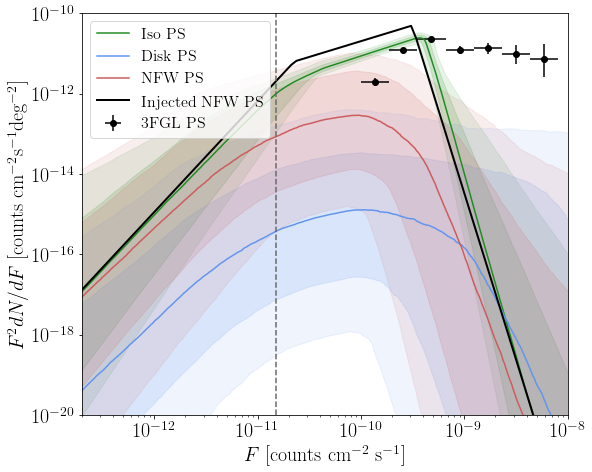

In [112]:
an.plot_source_count_median('iso_ps',smin=0.01,smax=1000,nsteps=1000,color='forestgreen',spow=2,label='Iso PS')
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='forestgreen',alpha=0.15,spow=2)
an.plot_source_count_band('iso_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='forestgreen',alpha=0.1,spow=2)

an.plot_source_count_median('dsk_ps',smin=0.01,smax=1000,nsteps=1000,color='cornflowerblue',spow=2,label='Disk PS')
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='cornflowerblue',alpha=0.15,spow=2)
an.plot_source_count_band('dsk_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='cornflowerblue',alpha=0.1,spow=2)

an.plot_source_count_median('nfw_ps',smin=0.01,smax=1000,nsteps=1000,color='indianred',spow=2,label='NFW PS')
an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='indianred',alpha=0.15,spow=2)
an.plot_source_count_band('nfw_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='indianred',alpha=0.1,spow=2)

# an.plot_source_count_median('bub_ps',smin=0.01,smax=1000,nsteps=1000,color='darkgoldenrod',spow=2,label='Bubbles PS')
# an.plot_source_count_band('bub_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.16,0.5,0.84],color='darkgoldenrod',alpha=0.15,spow=2)
# an.plot_source_count_band('bub_ps',smin=0.01,smax=1000,nsteps=1000,qs=[0.025,0.5,0.975],color='darkgoldenrod',alpha=0.1,spow=2)

plt.plot(f_ary0,f_ary0**2*rf*np.array([dNdF_2break(*sim_SCD[0:4],*sim_SCD[4:6]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected NFW PS')
plt.errorbar(x_counts,x_counts**2*y_counts,xerr=[x_errors_L,x_errors_H],yerr=x_counts**2*np.array([error_L,error_H]), fmt='o', color='black', label='3FGL PS')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(1e-20,1e-10)
plt.axvline(1/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**0.7/np.mean(fermi_exposure),ls='--',color='dimgray')
# plt.axvline(10**3.5/np.mean(fermi_exposure),ls='--',color='dimgray')

plt.legend(loc='upper left')

plt.ylabel('$F^2 dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]')
plt.xlabel('$F$  [counts cm$^{-2}$ s$^{-1}$]')
# plt.title(r'$m_\chi=100\,\mathrm{GeV},\langle\sigma v\rangle=10^{-26}\mathrm{cm}^3s^{-1},\,E_\gamma=2-20\,\mathrm{GeV}$')
plt.tight_layout()
# plt.savefig('plots/GCE_MC/kingPSF/F2dNdF_'+file_tag_types[filetype]+"_"+str(MC)+"_"+run_tag+'.pdf')

In [93]:
trueflux_bub = np.sum(~analysis_mask*bub_bf)/np.sum(~analysis_mask*(inj_sig_map+best_fit_bkg))

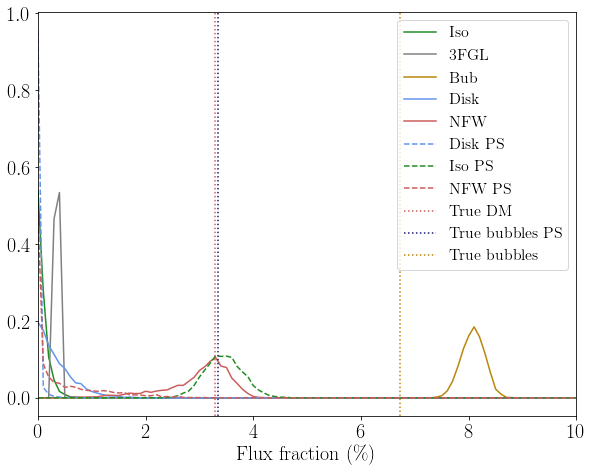

In [113]:
an.plot_intensity_fraction_poiss('iso', bins=1000, color='forestgreen', label='Iso',qs=[])
an.plot_intensity_fraction_poiss('psc', bins=1000, color='gray', label='3FGL',qs=[])
an.plot_intensity_fraction_poiss('bub', bins=1000, color='darkgoldenrod', label='Bub',qs=[])
an.plot_intensity_fraction_poiss('dsk', bins=1000, color='cornflowerblue', label='Disk',qs=[])
an.plot_intensity_fraction_poiss('nfw_dm', bins=1000, color='indianred', label='NFW',qs=[])

an.plot_intensity_fraction_non_poiss('dsk_ps',bins=1000, color='cornflowerblue', label='Disk PS',qs=[],ls='--')
an.plot_intensity_fraction_non_poiss('iso_ps',bins=1000, color='forestgreen', label='Iso PS',qs=[],ls='--')
an.plot_intensity_fraction_non_poiss('nfw_ps',bins=1000, color='indianred', label='NFW PS',qs=[],ls='--')
# an.plot_intensity_fraction_non_poiss('bub_ps',bins=1000, color='darkgoldenrod', label='Bubbles PS',qs=[],ls='--')

plt.axvline(trueflux_dm*100,ls='dotted',color='indianred',label='True DM')
plt.axvline(trueflux_ps*100,ls='dotted',color='midnightblue',label='True bubbles PS')
plt.axvline(trueflux_bub*100,ls='dotted',color='darkgoldenrod',label='True bubbles')

plt.legend(loc='upper right')
plt.xlim(0,10);
plt.xlabel(r'Flux fraction (\%)')
plt.tight_layout()
plt.savefig('plots/GCE_MC/kingPSF/flux_fractions_'+file_tag_types[filetype]+"_"+str(MC)+"_"+run_tag+'.pdf')



(1.0, 50000000000.0)

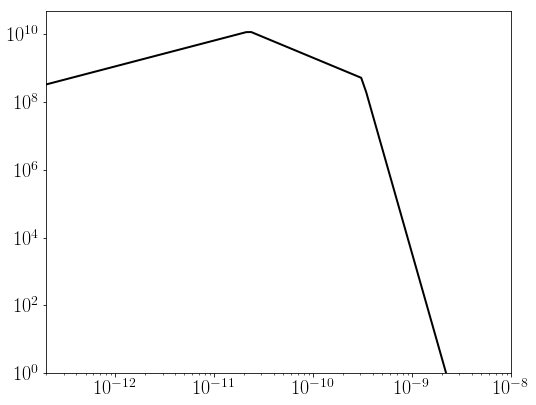

In [119]:
plt.plot(f_ary0,rf*np.array([dNdF_2break(*sim_SCD[0:4],*sim_SCD[4:6]/exp_masked_mean,f) for f in f_ary0]),linewidth=2,color='k',label='Injected PS')
plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-13,1e-8)
plt.ylim(1e0,5e10)